In [0]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 4.8MB/s 


In [0]:
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from pmdarima import auto_arima 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.statespace.sarimax import SARIMAX 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/Shihabtareq/Energy-Demand-of-Bangladesh/master/Eenrgy-demand.csv",parse_dates=True,index_col=['Year'])
df.head()

,Demand,Population,GDP
Year,,,
1994-01-01,2038,117,300
1995-01-01,2220,119,329
1996-01-01,2419,120,395
1997-01-01,2638,127,401
1998-01-01,2881,128,407


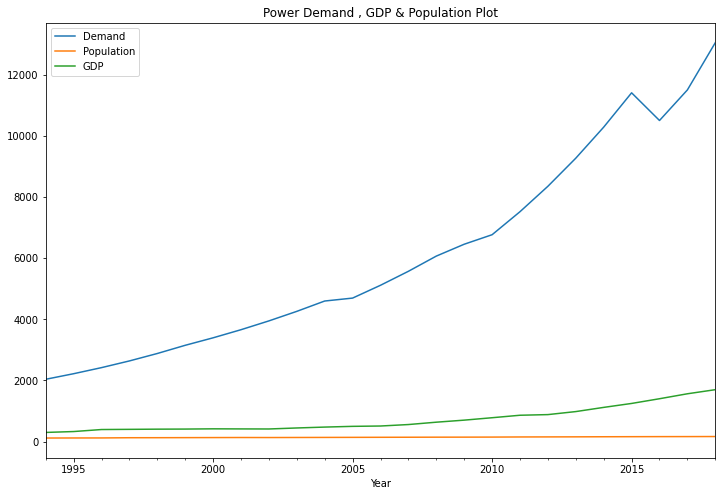

In [0]:
df.plot(figsize=(12,8))
plt.title("Power Demand , GDP & Population Plot")
pyplot.show()

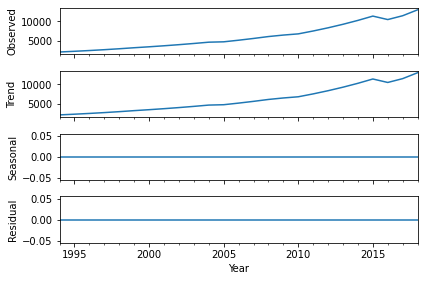

In [0]:
result = seasonal_decompose(df['Demand'])
result.plot();

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [0]:
adf_test(df['Demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic       3.443401
p-value                  1.000000
# lags used              5.000000
# observations          19.000000
critical value (1%)     -3.832603
critical value (5%)     -3.031227
critical value (10%)    -2.655520
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [0]:
diffDf = df.diff(1)

In [0]:
adf_test(diffDf['Demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.751183
p-value                  0.003448
# lags used              0.000000
# observations          23.000000
critical value (1%)     -3.752928
critical value (5%)     -2.998500
critical value (10%)    -2.638967
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [0]:
x=df[['Population','GDP']]

In [0]:

m = pm.auto_arima(df.Demand, exogenous=x,start_p=1, start_q=1,
                           max_p=5, max_q=5, 
                           seasonal=True,
                           d=1,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

m.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=370.295, BIC=377.363, Time=0.265 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=367.414, BIC=372.127, Time=0.038 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=369.231, BIC=375.121, Time=0.116 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=366.565, BIC=372.456, Time=0.201 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=367.138, BIC=370.672, Time=0.038 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=362.218, BIC=369.287, Time=0.205 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=365.490, BIC=373.736, Time=0.297 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the bo

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -175.109
Date:                Sat, 18 Apr 2020   AIC                            362.218
Time:                        07:47:57   BIC                            369.287
Sample:                    01-01-1994   HQIC                           364.094
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    273.3985    298.961      0.914      0.360    -312.553     859.351
Population   -26.4179    143.160     -0.185      0.854    -307.006     254.170
GDP            4.3209      2.225      1.942      0.052      -0.040       8.682
ma.L1         -0.4146      0.919     -0.451      0.652      -2.217       1.387
ma.L2         -0.5852      0.836     -0.700      0.484      -2.223       1.053
sigma2      1.157e+05      0.001   1.36e+08      0.000    1.16e+05    1.16e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                24.90
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):              75.22   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+27. Standard errors may be unstable.
"""

In [0]:
exog_forecast=df[['Population','GDP']]
#x=df['GDP']
model = SARIMAX(df['Demand'],exog=exog_forecast,order=(0,1,2),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 Demand   No. Observations:                   25
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -179.490
Date:                Sat, 18 Apr 2020   AIC                            368.980
Time:                        07:48:02   BIC                            374.870
Sample:                    01-01-1994   HQIC                           370.542
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population    63.6270     49.003      1.298      0.194     -32.417     159.671
GDP            4.8298      2.051      2.355      0.019       0.810       8.850
ma.L1         -0.1079      0.404     -0.267      0.789      -0.899       0.684
ma.L2         -0.3353      0.280     -1.200      0.230      -0.883       0.213
sigma2      1.689e+05   5.34e+04      3.161      0.002    6.42e+04    2.74e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                64.84
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               6.16   Skew:                            -2.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 1994-01-01 to 2018-01-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demand      25 non-null     int64
 1   Population  25 non-null     int64
 2   GDP         25 non-null     int64
dtypes: int64(3)
memory usage: 800.0 bytes


In [0]:
# Set four weeks for testing
train = df.iloc[:20]
test = df.iloc[20:]

In [0]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1


exog_forecast = test[['Population','GDP']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(0,1,2) Predictions')

[Text(0, 0.5, 'Visitors per day'), Text(0.5, 0, '')]

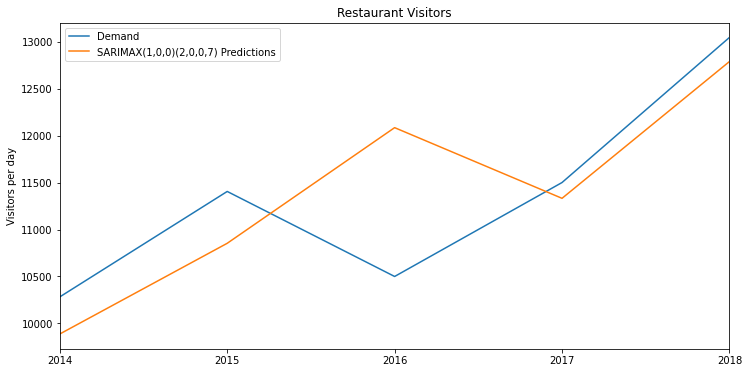

In [0]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['Demand'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [0]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual)/np.abs(actual)))*100  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [0]:
#error1x = mse(test['Demand'], predictions)
forecast_accuracy(predictions,test['Demand'])

{'corr': 0.6864992919381431,
 'mae': 591.0725615940021,
 'mape': 5.438617385988844,
 'me': 42.56138747994337,
 'minmax': 0.05043083384380753,
 'mpe': 0.005959916528106356,
 'rmse': 782.7868381183752}

In [0]:
Population = [169.123,172.221,179.98]  #population in million
GDP = [1828,2067,2239]                 #GDP per capita
d = {'Population':Population,'GDP':GDP}
exog_forecast = pd.DataFrame(d)
exog_forecast

,Population,GDP
0,169.123,1828
1,172.221,2067
2,179.980,2239


In [0]:
fcast = results.predict(len(df),len(df)+2,exog=exog_forecast).rename('SARIMAX(0,1,2)Forecast')

In [0]:
fcast

2019-01-01    13786.551504
2020-01-01    15051.974672
2021-01-01    16376.380513
Freq: AS-JAN, Name: SARIMAX(0,1,2)Forecast, dtype: float64

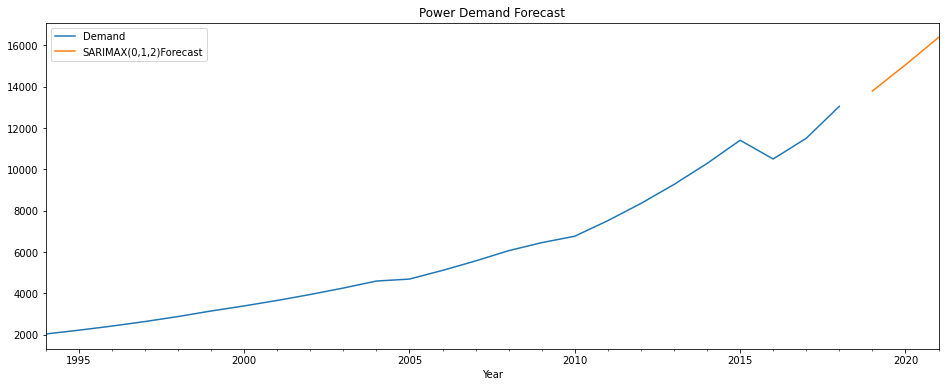

In [0]:
# Plot the forecast alongside historical values
title='Power Demand Forecast'
ylabel='Power in MW'
xlabel='Year'

ax = df['Demand'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)


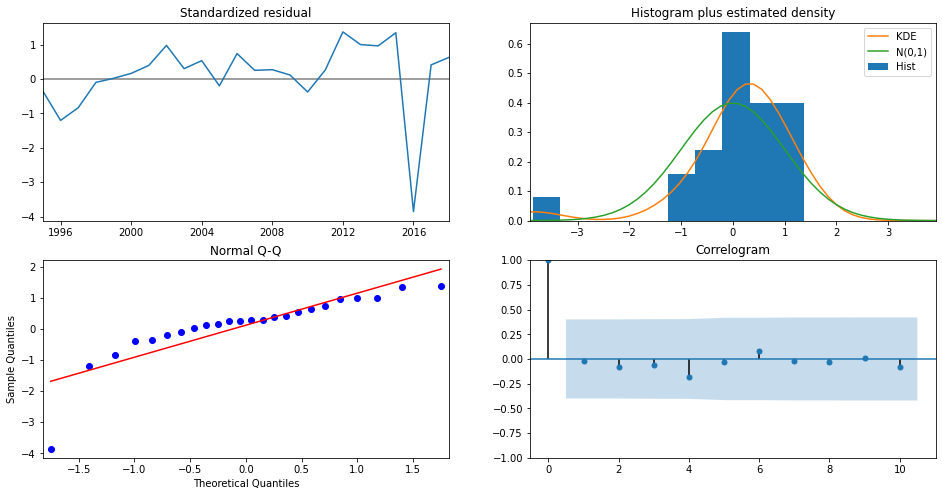

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Regression & ML

In [0]:
import sklearn as sk
import sklearn.metrics as skl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:

statMDL=smf.ols('Demand~GDP+Population', data= df).fit()
print(statMDL.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     746.9
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           6.02e-21
Time:                        08:27:44   Log-Likelihood:                -184.67
No. Observations:                  25   AIC:                             375.3
Df Residuals:                      22   BIC:                             379.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.306e+04   1753.722     -7.447      0.0

In [0]:
#Defining Features & Label
x = df[['Population','GDP']]
y = df['Demand']

In [0]:
#Building model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=5)
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#defining prediction data frame 
predictions = linreg.predict(x_test)

In [0]:
#model performance

print('Coefficients:', linreg.coef_)
print('Intercept:', linreg.intercept_)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
accuracy = linreg.score(x_test,y_test)
print('AccuracyII:',accuracy*100,'%')
print('R2:', r2_score(y_test, predictions))

Coefficients: [113.77251993   3.75825228]
Intercept: -12900.06226239265
MAE: 448.43900872673953
MSE: 363061.67263375164
RMSE: 602.5459921315149
AccuracyII: 96.75156403844466 %
R2: 0.9675156403844465


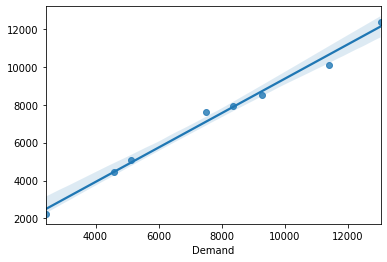

In [0]:
sns.regplot(x=y_test, y=predictions)

In [0]:
new_observation = [[166.586,11461.94]]
linreg.predict(new_observation)

array([49129.70888925])